In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import set_random_seed
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split as split_data
from tensorflow.keras.utils import plot_model
import os

Размер обучающего набора: 50000
Размер тестового набора: 50000


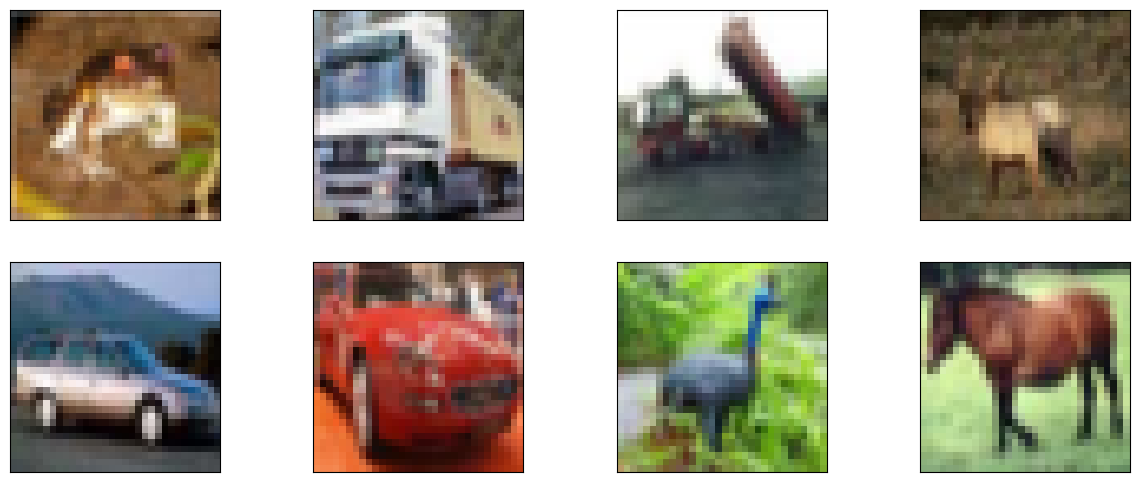

In [2]:
# Установка начального состояния для воспроизводимости результатов
set_random_seed(21)

# Загрузка набора данных CIFAR-10
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print(f"Размер обучающего набора: {len(X_train)}\nРазмер тестового набора: {len(X_train)}")

def plot_images(images, rows=2, cols=4, figsize=(15,6)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_xticks([]) 
            ax.set_yticks([]) 
        else:
            ax.axis('off') 
    plt.show()

random_images = [X_train[i] for i in range(8)]

plot_images(random_images)

In [3]:
len(X_train), len(X_test)

X_valid, X_test, y_valid, y_test = tts(X_test, y_test, test_size=0.2, random_state=21)

len(X_test), len(X_valid)

X_train.shape

X_train = X_train/255
X_test = X_test/255
X_valid = X_valid/255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)

X_dataset_train = tf.data.Dataset.from_tensor_slices(X_train)
y_dataset_train = tf.data.Dataset.from_tensor_slices(y_train)

dataset_train = tf.data.Dataset.zip((X_dataset_train, y_dataset_train))

X_dataset_valid = tf.data.Dataset.from_tensor_slices(X_valid)
y_dataset_valid = tf.data.Dataset.from_tensor_slices(y_valid)

dataset_valid = tf.data.Dataset.zip((X_dataset_valid, y_dataset_valid))

dataset_train = dataset_train.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

X_dataset_test = tf.data.Dataset.from_tensor_slices(X_test)
y_dataset_test = tf.data.Dataset.from_tensor_slices(y_test)

dataset_test = tf.data.Dataset.zip((X_dataset_test, y_dataset_test))
dataset_test = dataset_test.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)


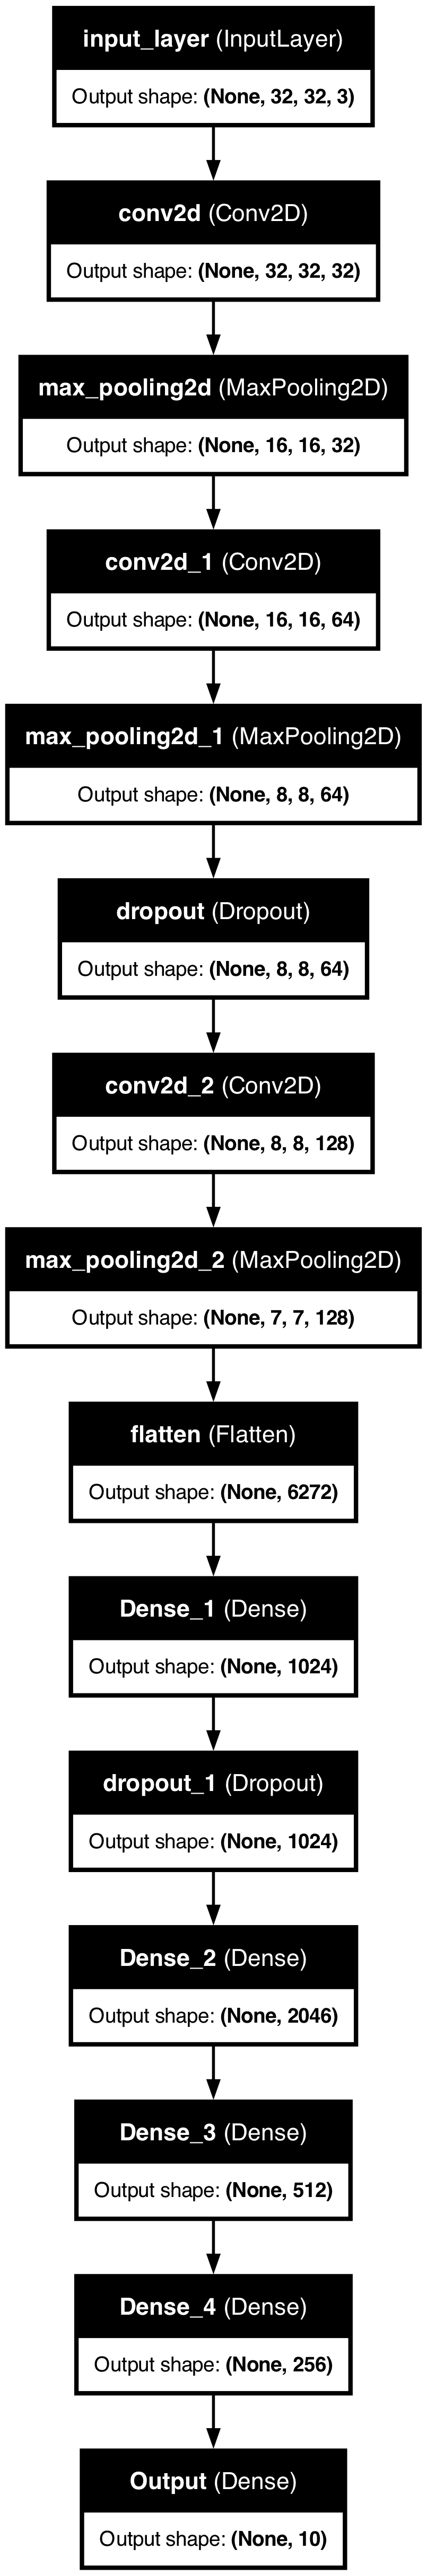

In [4]:
inputs = keras.Input(shape = (32,32,3))
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu')(x)
x = keras.layers.MaxPooling2D((2, 2), strides=1)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation="relu", name='Dense_1')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(2046, activation='relu', name='Dense_2')(x)
x = keras.layers.Dense(512, activation='relu', name='Dense_3')(x)
x = keras.layers.Dense(256, activation='relu', name='Dense_4')(x)
output = keras.layers.Dense(10, activation='softmax', name='Output')(x)

model = keras.models.Model(inputs=inputs, outputs=output)

# Визуализация архитектуры модели
plot_model(model, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [5]:
model.compile(keras.optimizers.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), keras.metrics.Precision(), keras.metrics.Recall()],)

history = model.fit(dataset_train, validation_data=dataset_valid, 
                    epochs=20, callbacks=tf.keras.callbacks.TensorBoard(log_dir='Exp1_logs'))

eval_hist = model.evaluate(dataset_test)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - f1_score: 0.2309 - loss: 1.9865 - precision: 0.4462 - recall: 0.0377 - val_f1_score: 0.4311 - val_loss: 1.5187 - val_precision: 0.7086 - val_recall: 0.1654
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - f1_score: 0.4901 - loss: 1.3885 - precision: 0.6807 - recall: 0.2804 - val_f1_score: 0.5734 - val_loss: 1.2350 - val_precision: 0.7727 - val_recall: 0.3416
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 35s 179ms/step - f1_score: 0.5576 - loss: 1.2108 - precision: 0.7206 - recall: 0.3895 - val_f1_score: 0.6048 - val_loss: 1.0978 - val_precision: 0.7604 - val_recall: 0.4412
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - f1_score: 0.6063 - loss: 1.0952 - precision: 0.7485 - recall: 0.4623 - val_f1_score: 0.6565 - val_loss: 0.9789 - val_precision: 0.7903 - val_recall: 0.5075
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - f1_score: 0.6483 - loss: 0.9842 - precision: 0.7705 - recall: 0.5249 - val_f1_score: 0.6525

In [6]:
print(
    f"Eval_loss = {eval_hist[0]:.4f} \n"
    f"Eval_f1 = {eval_hist[1]:.4f} \n"
    f"Eval_precision = {eval_hist[2]:.4f} \n"
    f"Eval_recall = {eval_hist[3]:.4f}"
)

Eval_loss = 0.6965 
Eval_f1 = 0.7808 
Eval_precision = 0.8122 
Eval_recall = 0.7545


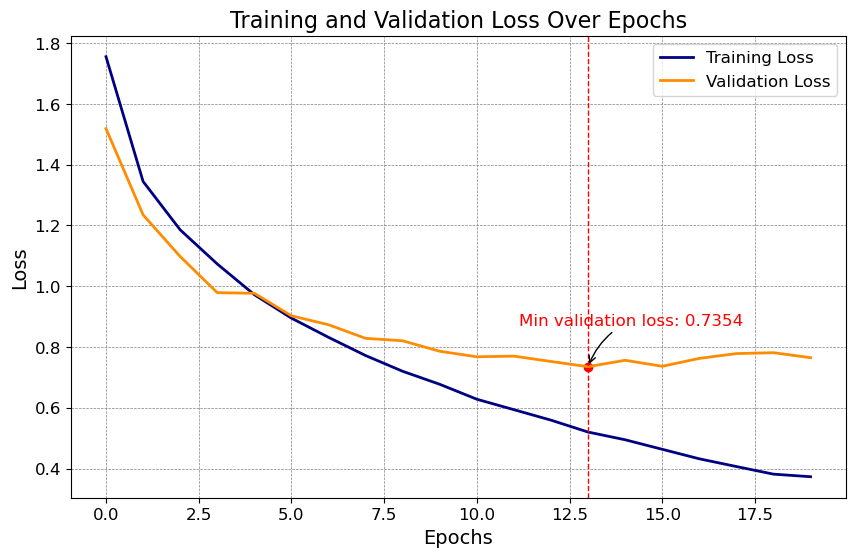

In [7]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(10, 6))
plt.plot(history_df['loss'], label='Training Loss', color='navy', linewidth=2)
plt.plot(history_df['val_loss'], label='Validation Loss', color='darkorange', linewidth=2)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

min_val_loss_idx = history_df['val_loss'].idxmin() # индекс минимального значения валидационной потери
min_val_loss = history_df['val_loss'].min()
plt.axvline(x=min_val_loss_idx, linestyle='--', color='red', linewidth=1, label='Lowest validation loss')
plt.scatter(min_val_loss_idx, min_val_loss, color='red') 

plt.annotate(f'Min validation loss: {min_val_loss:.4f}',
             xy=(min_val_loss_idx, min_val_loss),
             xycoords='data',
             xytext=(-50, 30),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
             fontsize=12,
             color='red')

plt.show()

Index(['f1_score', 'loss', 'precision', 'recall', 'val_f1_score', 'val_loss',
       'val_precision', 'val_recall'],
      dtype='object')


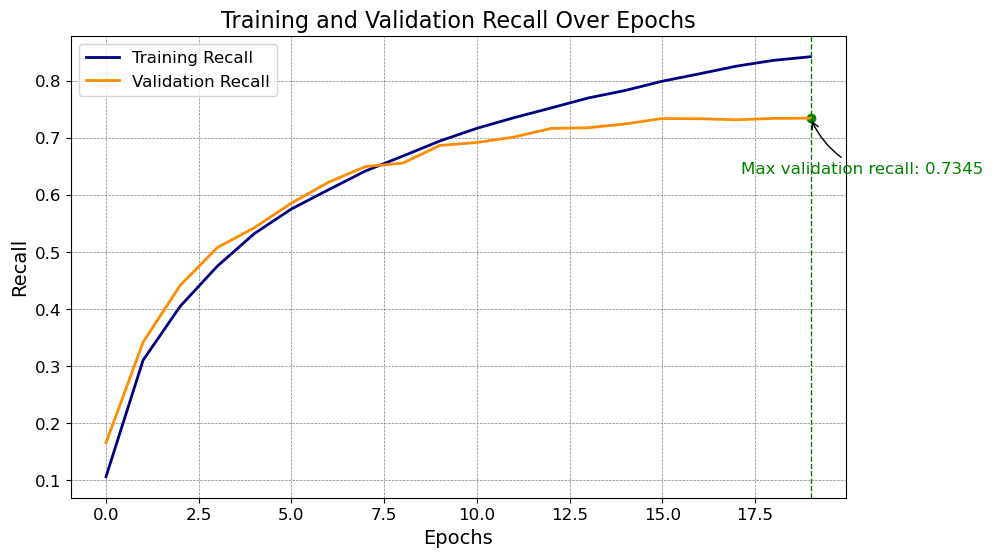

In [9]:
print(history_df.keys())

plt.figure(figsize=(10, 6))

plt.plot(history_df['recall'], label='Training Recall', color='navy', linewidth=2)
plt.plot(history_df['val_recall'], label='Validation Recall', color='darkorange', linewidth=2)
plt.title('Training and Validation Recall Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_recall_idx = history_df['val_recall'].idxmax() # индекс максимального значения валидационного recall
max_val_recall = history_df['val_recall'].max()
plt.axvline(x=max_val_recall_idx, linestyle='--', color='green', linewidth=1, label='Highest validation recall')
plt.scatter(max_val_recall_idx, max_val_recall, color='green')

plt.annotate(f'Max validation recall: {max_val_recall:.4f}',
             xy=(max_val_recall_idx, max_val_recall),
             xycoords='data',
             xytext=(-50, -40),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"),
             fontsize=12,
             color='green')

plt.show()

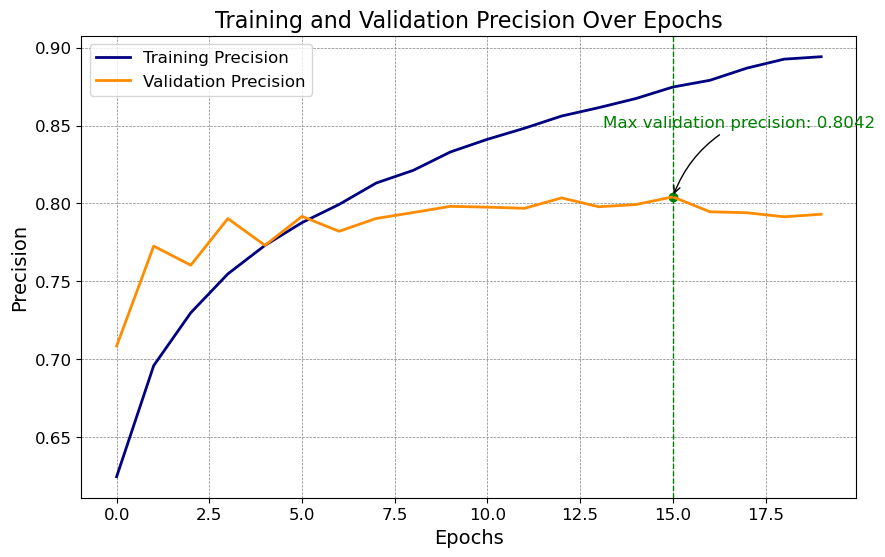

In [10]:
plt.figure(figsize=(10, 6))

plt.plot(history_df['precision'], label='Training Precision', color='navy', linewidth=2)
plt.plot(history_df['val_precision'], label='Validation Precision', color='darkorange', linewidth=2)
plt.title('Training and Validation Precision Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_precision_idx = history_df['val_precision'].idxmax()
max_val_precision = history_df['val_precision'].max()
plt.axvline(x=max_val_precision_idx, linestyle='--', color='green', linewidth=1, label='Highest validation precision')
plt.scatter(max_val_precision_idx, max_val_precision, color='green')

plt.annotate(f'Max validation precision: {max_val_precision:.4f}',
             xy=(max_val_precision_idx, max_val_precision),
             xycoords='data',
             xytext=(-50, 50),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
             fontsize=12,
             color='green')

plt.show()


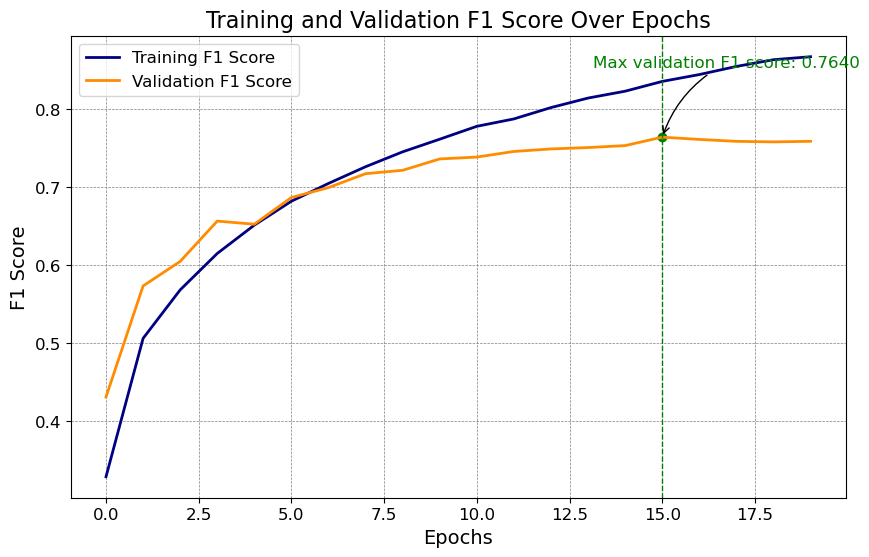

In [11]:
plt.figure(figsize=(10, 6))

plt.plot(history_df['f1_score'], label='Training F1 Score', color='navy', linewidth=2)
plt.plot(history_df['val_f1_score'], label='Validation F1 Score', color='darkorange', linewidth=2)
plt.title('Training and Validation F1 Score Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_f1_score_idx = history_df['val_f1_score'].idxmax()
max_val_f1_score = history_df['val_f1_score'].max()
plt.axvline(x=max_val_f1_score_idx, linestyle='--', color='green', linewidth=1, label='Highest validation F1 score')
plt.scatter(max_val_f1_score_idx, max_val_f1_score, color='green')
plt.annotate(f'Max validation F1 score: {max_val_f1_score:.4f}',
             xy=(max_val_f1_score_idx, max_val_f1_score),
             xycoords='data',
             xytext=(-50, 50), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
             fontsize=12,
             color='green')

plt.show()

In [88]:
preds = model.predict(X_valid)

preds = np.argmax(preds, axis=1)
y_valid_idx = np.argmax(y_valid, axis=1)

print(classification_report(y_valid_idx, preds))

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       792
           1       0.80      0.93      0.86       811
           2       0.67      0.66      0.67       801
           3       0.53      0.58      0.56       792
           4       0.71      0.73      0.72       804
           5       0.65      0.65      0.65       798
           6       0.84      0.81      0.83       786
           7       0.83      0.78      0.81       801
           8       0.89      0.84      0.86       806
           9       0.88      0.79      0.83       809

    accuracy                           0.76      8000
   macro avg       0.76      0.76      0.76      8000
weighted avg       0.76      0.76      0.76      8000



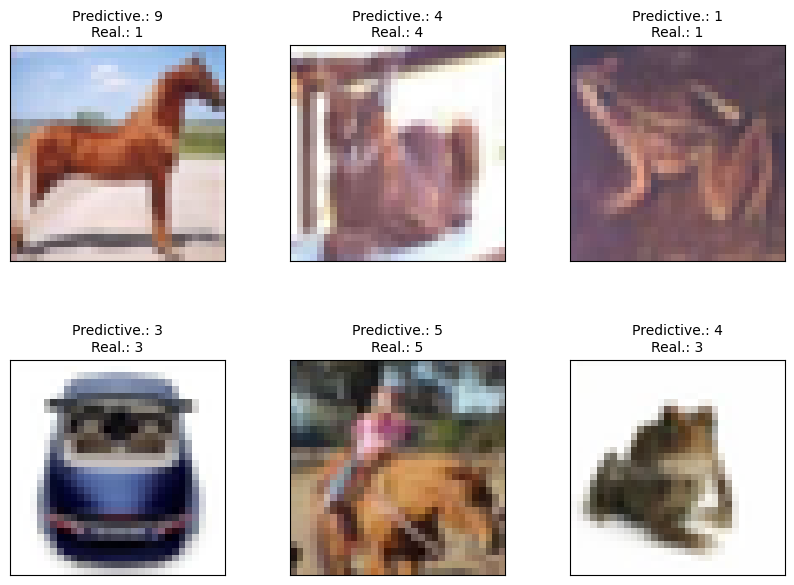

In [89]:
h, w = (2, 3)
fig, axs = plt.subplots(h, w, figsize=(10, 7)) 

plt.subplots_adjust(hspace=0.4, wspace=0.3) 

for i in range(h):
    for j in range(w):
        num = np.random.randint(len(X_test))  
        ax = axs[i, j]
        ax.imshow(X_test[num])  
        predicted_class = str(preds[num])  
        real_class = str(y_valid_idx[num])  
        
        ax.set_title(f'Predictive.: {predicted_class}\nReal.: {real_class}', fontsize=10)  
        ax.set(xticks=[], yticks=[]) 

plt.show()

In [24]:
import os

model_dir = 'Models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, 'model_1.keras')
model.save(model_path)

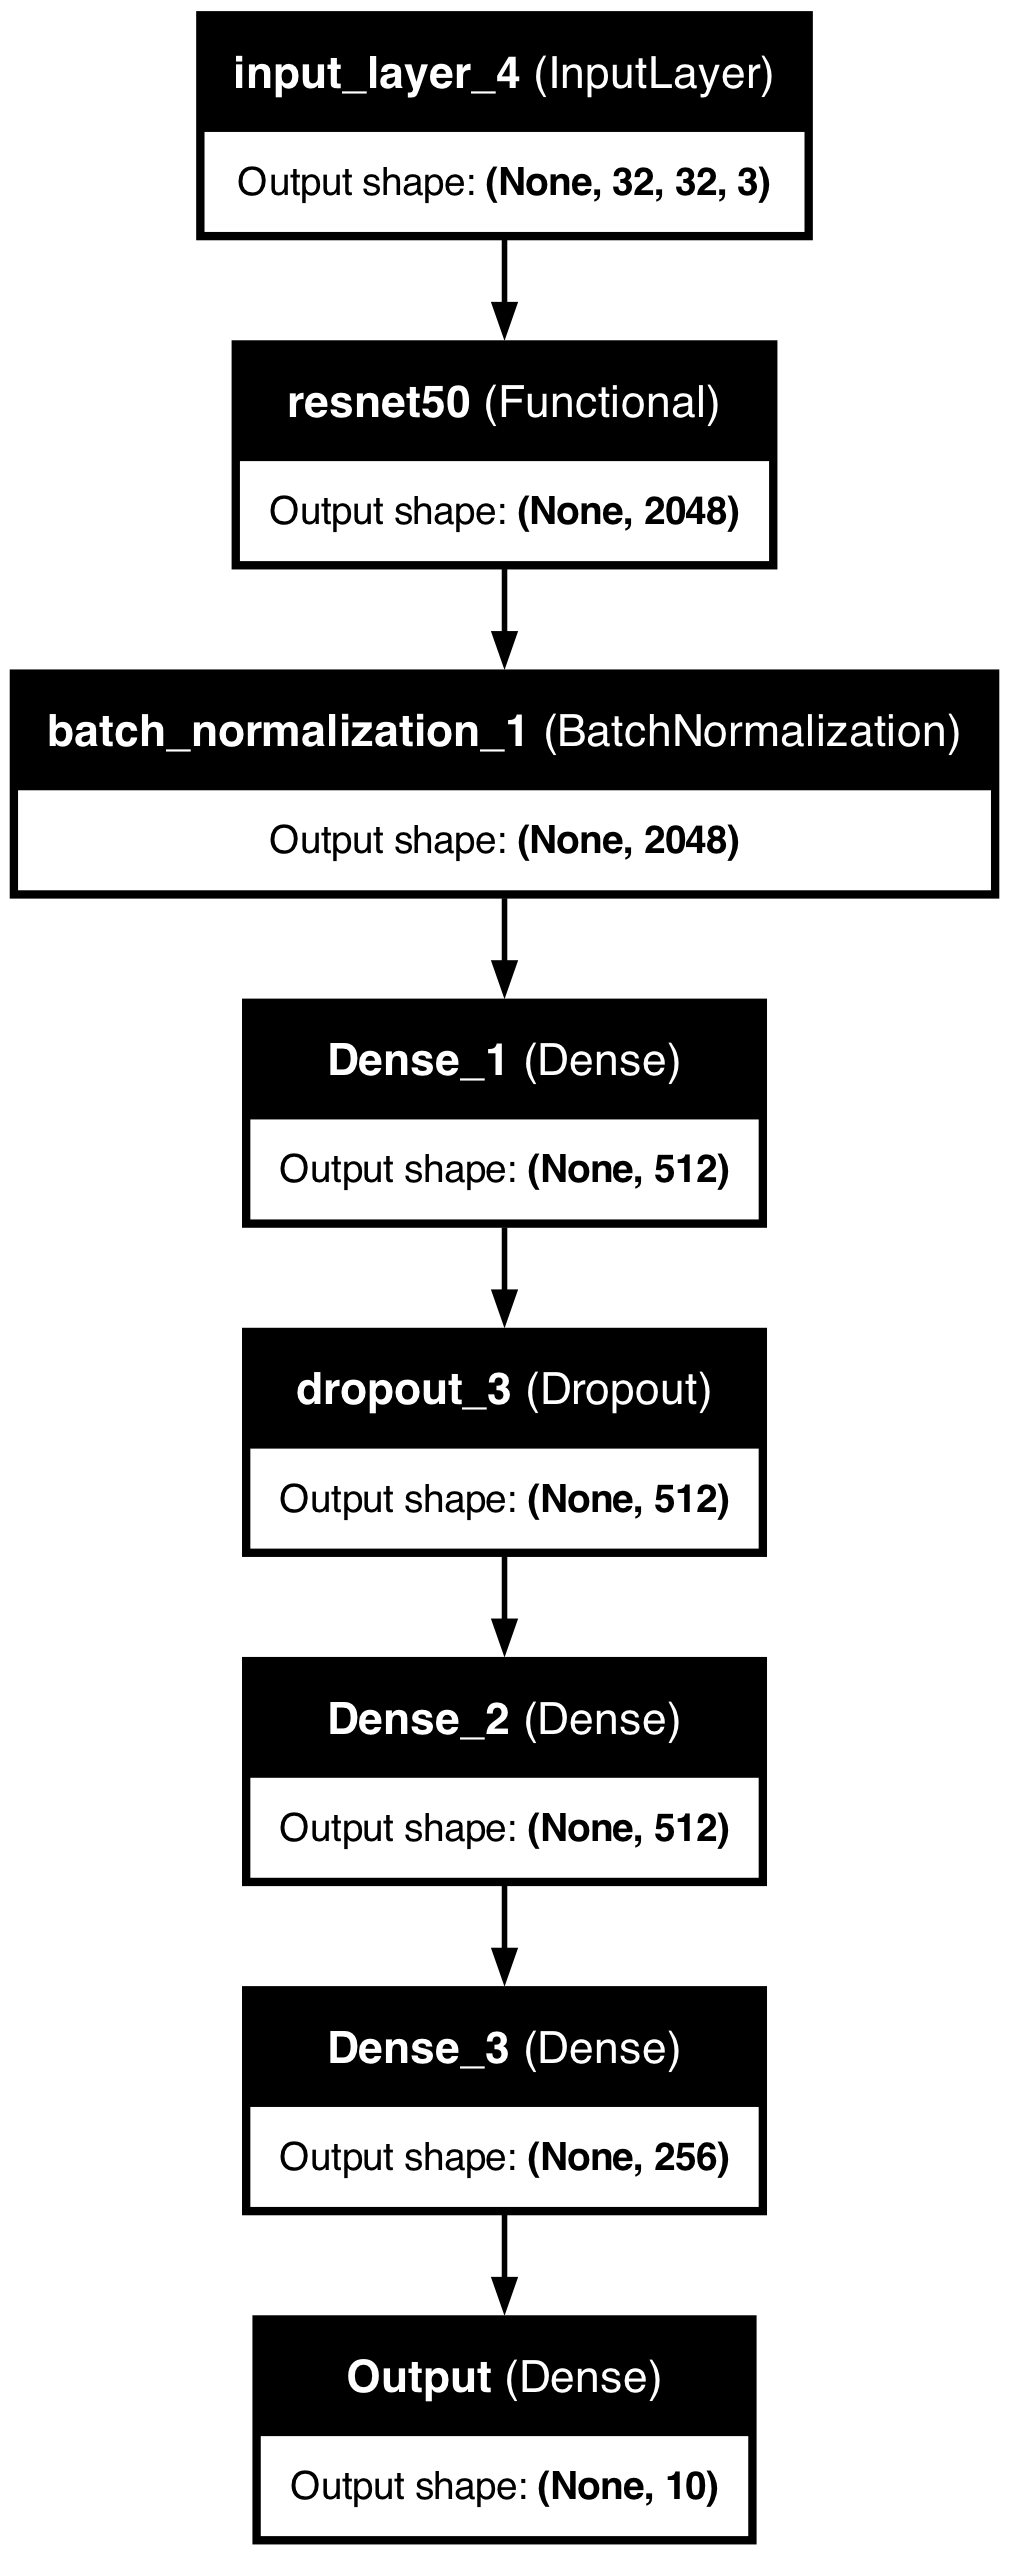

In [27]:
# Exp 2
# Предобученный бэкбон resnet50
from keras.utils import plot_model

base_resnet = keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top=False, input_shape=(32,32,3), pooling = 'avg')

inputs = keras.Input(shape = (32,32,3))
x = base_resnet(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", name='Dense_1')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation='relu', name='Dense_2')(x)
x = keras.layers.Dense(256, activation='relu', name='Dense_3')(x)
output = keras.layers.Dense(10, activation='softmax', name='Output')(x)

model_2 = keras.models.Model(inputs = inputs, outputs = output)

plot_model(model_2, to_file='model_2.png', show_shapes=True, show_layer_names=True)

In [33]:
model_2.compile(keras.optimizers.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), keras.metrics.Precision(), keras.metrics.Recall()])

tensorboard = tf.keras.callbacks.TensorBoard(log_dir="Exp2_logs")
learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
history_2 = model_2.fit(dataset_train, validation_data=dataset_valid, 
                    epochs=10, callbacks=[learn_rate_red, early_stop, tensorboard])

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - f1_score: 0.4979 - loss: 1.4360 - precision_6: 0.7077 - recall_6: 0.3454 - val_f1_score: 0.0178 - val_loss: 3.7114 - val_precision_6: 0.0990 - val_recall_6: 0.0990 - learning_rate: 5.0000e-04
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - f1_score: 0.7797 - loss: 0.6584 - precision_6: 0.8453 - recall_6: 0.7173 - val_f1_score: 0.0434 - val_loss: 2.9706 - val_precision_6: 0.5000 - val_recall_6: 3.7500e-04 - learning_rate: 5.0000e-04
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - f1_score: 0.8491 - loss: 0.4522 - precision_6: 0.8897 - recall_6: 0.8143 - val_f1_score: 0.1461 - val_loss: 2.8024 - val_precision_6: 0.2339 - val_recall_6: 0.0775 - learning_rate: 5.0000e-04
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - f1_score: 0.8885 - loss: 0.3347 - precision_6: 0.9134 - recall_6: 0.8643 - val_f1_score: 0.4161 - val_loss: 2.9099 - val_precision_6: 0.4475 - val_recall_6: 0.4099 - learning_rate: 5.0000e-04
Epoch 5/

In [34]:
eval_hist_2 = model_2.evaluate(dataset_test)

results_template = (
    "Eval_loss = {:.4f} \n"
    "Eval_f1 = {:.4f} \n"
    "Eval_precision = {:.4f} \n"
    "Eval_recall = {:.4f}"
)

print(results_template.format(eval_hist_2[0], 
                              eval_hist_2[1], 
                              eval_hist_2[2],
                              eval_hist_2[3]))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - f1_score: 0.8473 - loss: 0.6946 - precision_6: 0.8527 - recall_6: 0.8419
Eval_loss = 0.7290 
Eval_f1 = 0.8406 
Eval_precision = 0.8470 
Eval_recall = 0.8330


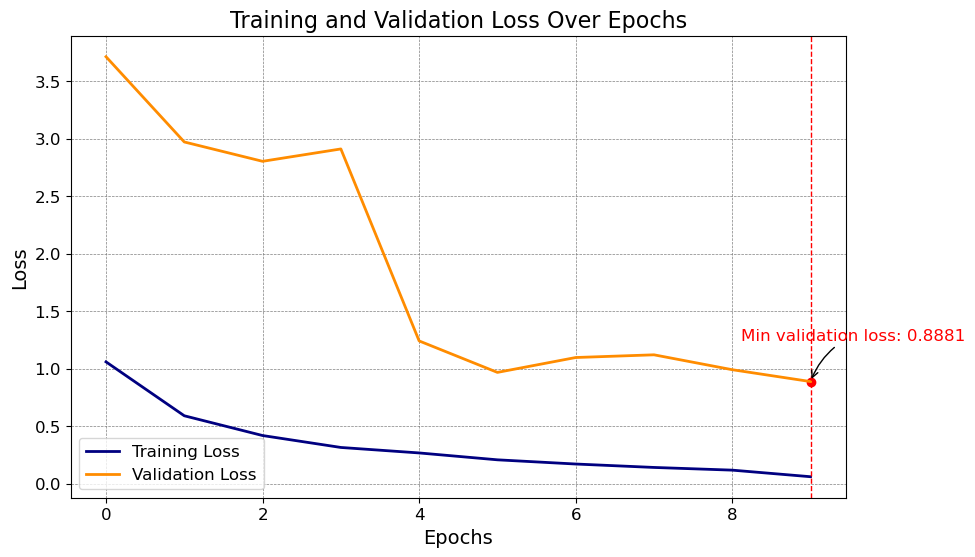

In [35]:
#График изменения функции потерь
history_df = pd.DataFrame(history_2.history)

plt.figure(figsize=(10, 6))
plt.plot(history_df['loss'], label='Training Loss', color='navy', linewidth=2)
plt.plot(history_df['val_loss'], label='Validation Loss', color='darkorange', linewidth=2)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

min_val_loss_idx = history_df['val_loss'].idxmin()
min_val_loss = history_df['val_loss'].min()
plt.axvline(x=min_val_loss_idx, linestyle='--', color='red', linewidth=1, label='Lowest validation loss')
plt.scatter(min_val_loss_idx, min_val_loss, color='red')

plt.annotate(f'Min validation loss: {min_val_loss:.4f}',
             xy=(min_val_loss_idx, min_val_loss),
             xycoords='data',
             xytext=(-50, 30),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
             fontsize=12,
             color='red')

plt.show()

In [36]:
print(history_df.columns)

Index(['f1_score', 'loss', 'precision_6', 'recall_6', 'val_f1_score',
       'val_loss', 'val_precision_6', 'val_recall_6', 'learning_rate'],
      dtype='object')


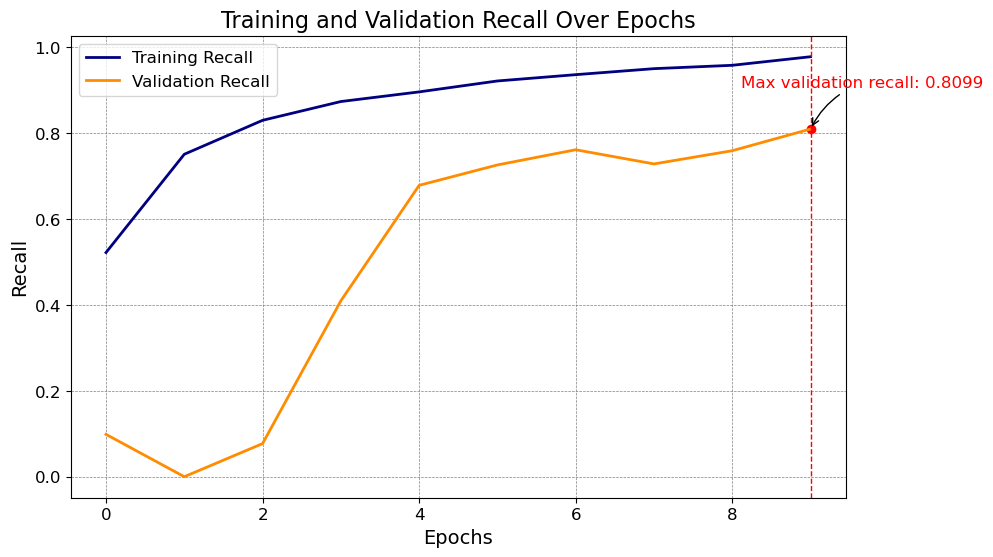

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['recall_6'], label='Training Recall', color='navy', linewidth=2)
plt.plot(history_df['val_recall_6'], label='Validation Recall', color='darkorange', linewidth=2)
plt.title('Training and Validation Recall Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_recall_idx = history_df['val_recall_6'].idxmax() 
max_val_recall = history_df['val_recall_6'].max()
plt.axvline(x=max_val_recall_idx, linestyle='--', color='red', linewidth=1, label='Highest Validation Recall')
plt.scatter(max_val_recall_idx, max_val_recall, color='red') # Точка максимального значения Validation Recall

plt.annotate(f'Max validation recall: {max_val_recall:.4f}',
             xy=(max_val_recall_idx, max_val_recall),
             xycoords='data',
             xytext=(-50, 30), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
             fontsize=12,
             color='red')

plt.show()

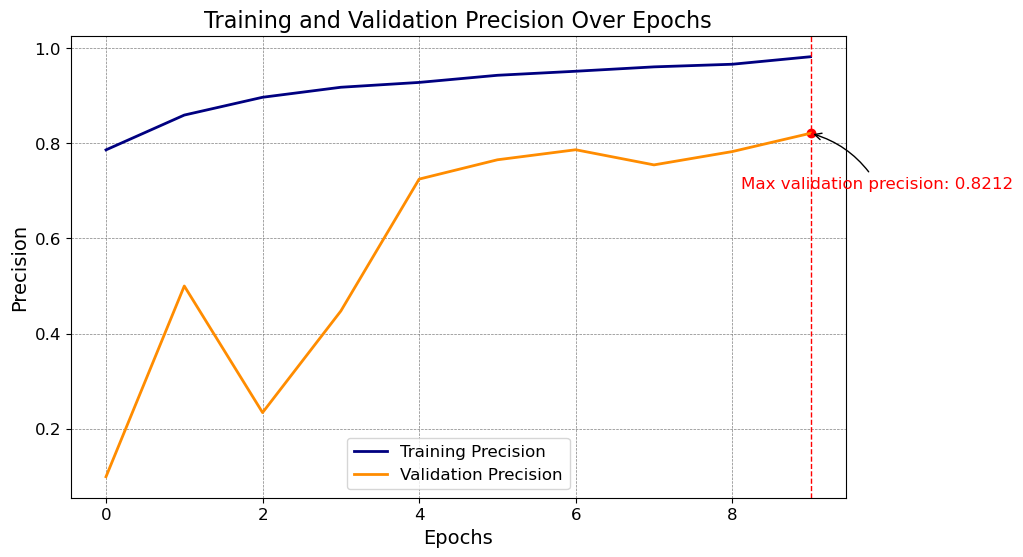

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['precision_6'], label='Training Precision', color='navy', linewidth=2)
plt.plot(history_df['val_precision_6'], label='Validation Precision', color='darkorange', linewidth=2)
plt.title('Training and Validation Precision Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)

max_val_precision_idx = history_df['val_precision_6'].idxmax() 
max_val_precision = history_df['val_precision_6'].max()
plt.axvline(x=max_val_precision_idx, linestyle='--', color='red', linewidth=1, label='Highest Validation Precision')
plt.scatter(max_val_precision_idx, max_val_precision, color='red')  # Точка максимального значения Validation Precision

plt.annotate(f'Max validation precision: {max_val_precision:.4f}',
             xy=(max_val_precision_idx, max_val_precision),
             xycoords='data',
             xytext=(-50, -40), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
             fontsize=12,
             color='red')

plt.show()

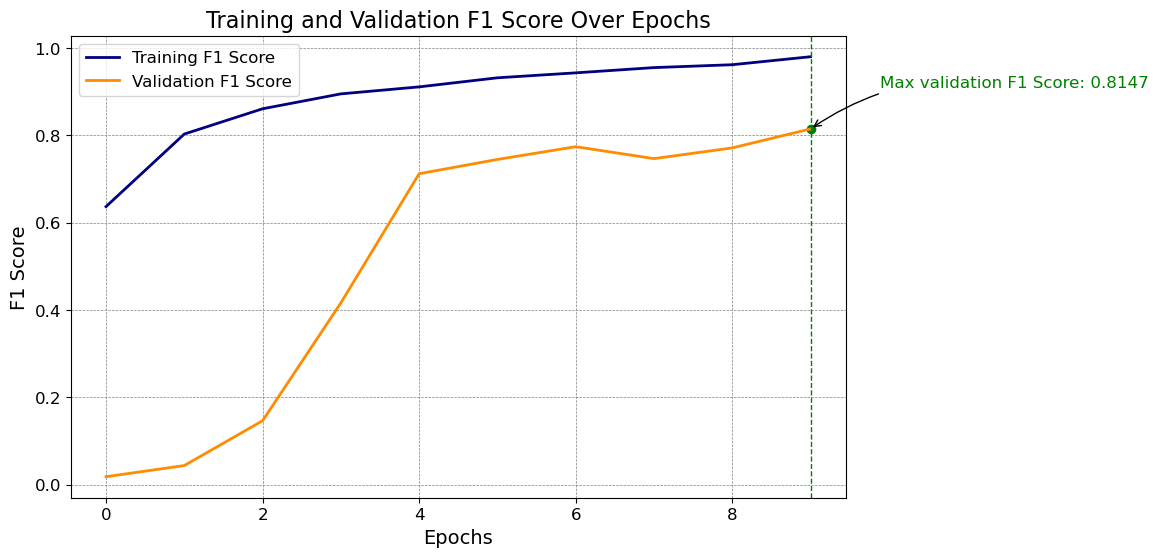

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['f1_score'], label='Training F1 Score', color='navy', linewidth=2)
plt.plot(history_df['val_f1_score'], label='Validation F1 Score', color='darkorange', linewidth=2)
plt.title('Training and Validation F1 Score Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey')
plt.legend(fontsize=12)
max_val_f1_idx = history_df['val_f1_score'].idxmax() 
max_val_f1 = history_df['val_f1_score'].max()
plt.axvline(x=max_val_f1_idx, linestyle='--', color='green', linewidth=1, label='Highest Validation F1 Score')
plt.scatter(max_val_f1_idx, max_val_f1, color='green')  # Точка максимального значения F1 Score

plt.annotate(f'Max validation F1 Score: {max_val_f1:.4f}',
             xy=(max_val_f1_idx, max_val_f1),
             xycoords='data',
             xytext=(50, 30),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
             fontsize=12,
             color='green')

plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       208
           1       0.96      0.85      0.90       189
           2       0.78      0.80      0.79       199
           3       0.65      0.74      0.69       208
           4       0.80      0.82      0.81       196
           5       0.84      0.73      0.78       202
           6       0.92      0.79      0.85       214
           7       0.87      0.89      0.88       199
           8       0.90      0.92      0.91       194
           9       0.83      0.95      0.89       191

    accuracy                           0.84      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.85      0.84      0.84      2000



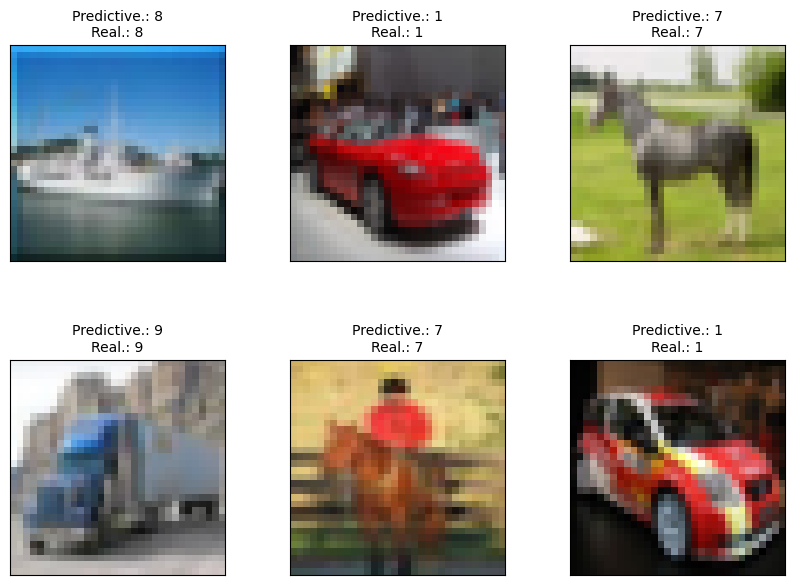

In [92]:
preds = model_2.predict(X_test)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)

print(classification_report(y_test_idx, preds))

h, w = (2, 3)
fig, axs = plt.subplots(h, w, figsize=(10, 7)) 

plt.subplots_adjust(hspace=0.4, wspace=0.3) 

for i in range(h):
    for j in range(w):
        num = np.random.randint(len(X_test))  
        ax = axs[i, j]
        ax.imshow(X_test[num])  
        predicted_class = str(preds[num])  
        real_class = str(y_test_idx[num])  
        
        ax.set_title(f'Predictive.: {predicted_class}\nReal.: {real_class}', fontsize=10)  
        ax.set(xticks=[], yticks=[]) 

plt.show()

In [82]:
model_2.save('Models/model_2.keras')